### Assignment-2

**Objective:**

Build and experiment with advanced LSTM model variant for RUL prediction.

1. Imports necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional,Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2. Data Loading

In [ ]:
X=np.load("/content/drive/MyDrive/rolling_window_sequences.npy")
metadata = pd.read_csv("/content/drive/MyDrive/sequence_metadata_with_RUL.csv")
y=metadata['RUL'].values

print(X.shape)
print(y.shape)

(17631, 30, 66)
(17631,)


3. Train/Validation Split

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Example X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (14104, 30, 66) (14104,)
Val shape: (3527, 30, 66) (3527,)
Example X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 74.  41.  43.  33. 101.]


4. Define Model Architectures

In [ ]:
def build_bidirectional_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=False),
                      input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model


5. Instantiate and compile models

In [ ]:
model_bidirectional = build_bidirectional_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model_bidirectional.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_bidirectional.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,201 (262.50 KB)

 Trainable params: 67,201 (262.50 KB)

 Non-trainable params: 0 (0.00 B)

6. Prepare datasets for training

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

7. Setup callbacks

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint(
    "best_lstm_model.keras", save_best_only=True, monitor="val_loss", verbose=1
)

8. Train and compare models

In [ ]:
history_bidirectional = model_bidirectional.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stop,reduce_lr,model_ckpt]
)

Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7386.3882
Epoch 1: val_loss improved from inf to 4228.68848, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 7381.0103 - val_loss: 4228.6885 - learning_rate: 0.0010
Epoch 2/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3689.5220
Epoch 2: val_loss improved from 4228.68848 to 2481.80493, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3679.9741 - val_loss: 2481.8049 - learning_rate: 0.0010
Epoch 3/100
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2185.3928
Epoch 3: val_loss improved from 2481.80493 to 1496.39526, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2181.1138 - val_loss: 1496.3953 - learning_rate: 0.0010
Epoch 4/100
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1340.0912
Epoch 4: val_loss improved from 1496.39526 to 950.93066, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━

9. Plot training and validation loss curve function

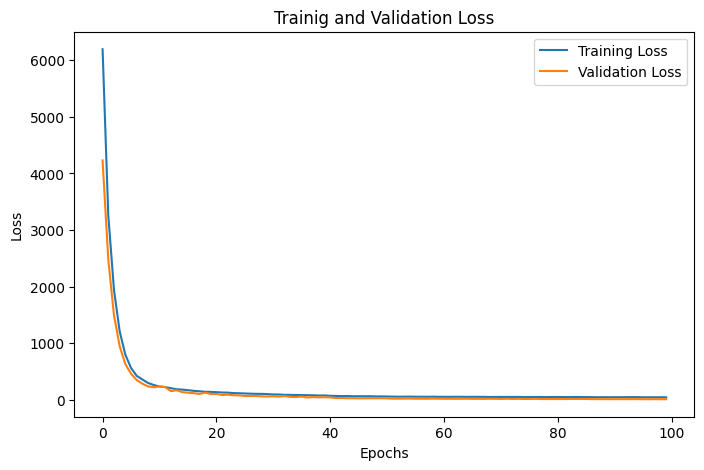

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_bidirectional.history['loss'], label='Training Loss')
plt.plot(history_bidirectional.history['val_loss'], label='Validation Loss')
plt.title('Trainig and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


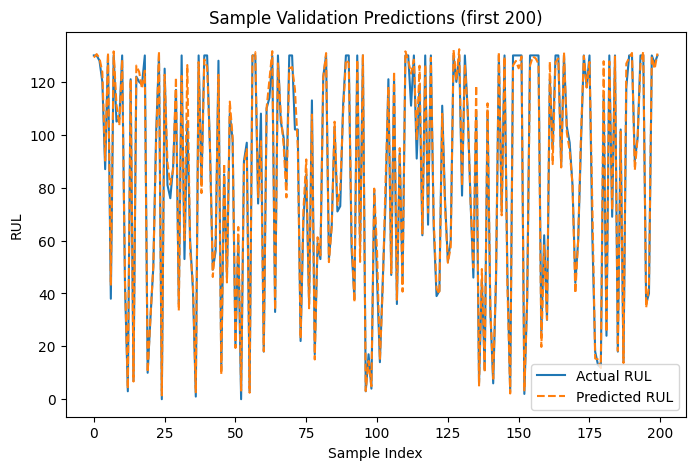

In [ ]:
val_pred = model_bidirectional.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()

10. Provide Final Report of this Experiement.

The implemented Bidirectional LSTM provides a simple, well-structured baseline for RUL regression from time-windowed sensor data. The training pipeline uses sensible callbacks and an appropriate loss function.

Training and validation loss curves were plotted to observe convergence and overfitting tendencies. The curves showed a rapid decrease in loss for both training and validation datasets, indicating effective learning and good generalization without significant overfitting.

A sample of predicted vs actual RUL for the first 200 validation samples was plotted to visually assess predictive performance. The plot demonstrated that the model was able to capture the overall trend of the RUL, with predicted values closely following the actual values for many samples.